# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [4]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [5]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [6]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [7]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [8]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [9]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [10]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [11]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [12]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [13]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

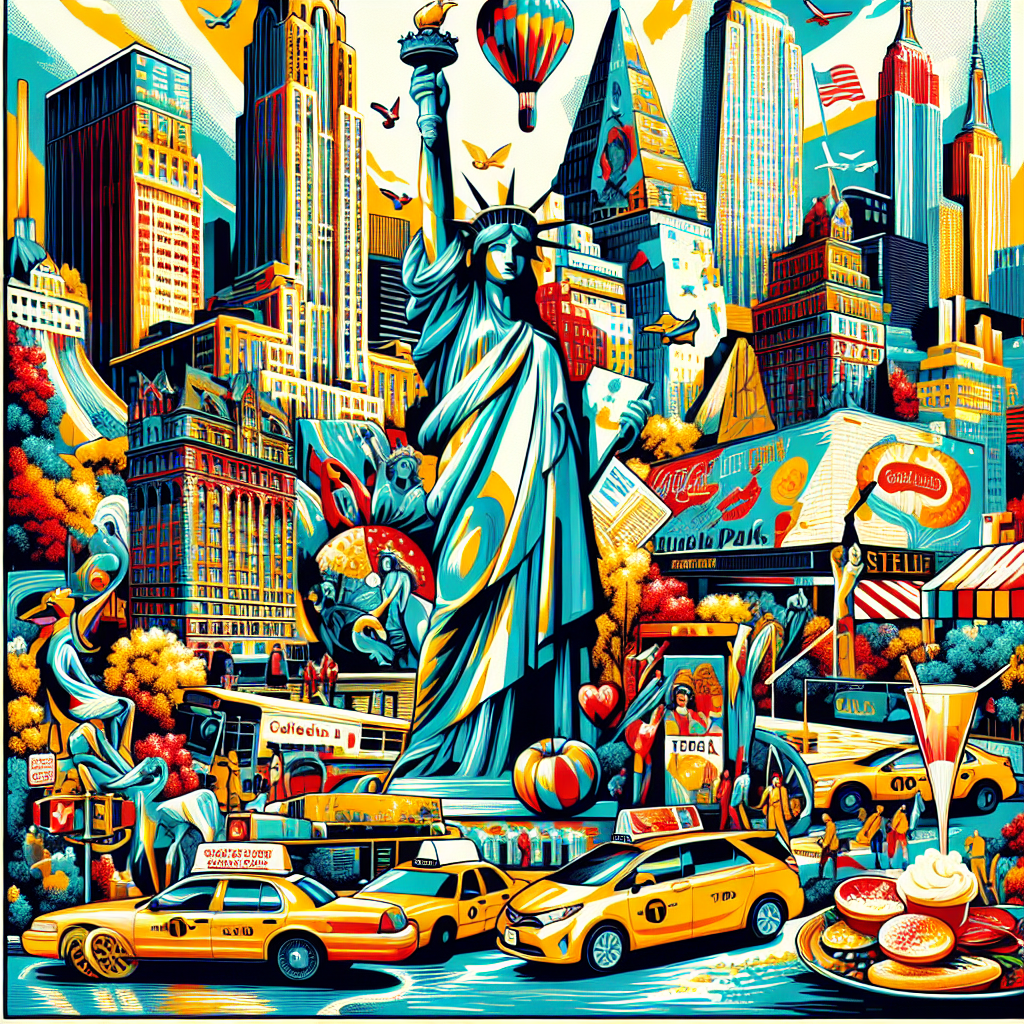

In [14]:
image = artist("New York City")
display(image)

In [15]:
image = artist("Mumbai City")
display(image)

## Audio

And let's make a function talker that uses OpenAI's speech model to generate Audio

# For Windows users (or any Mac users with problems above)

## First try the Mac version above, but if you get a permissions error writing to a temp file, then this code should work instead.

A collaboration between students Mark M. and Patrick H. and Claude got this resolved!

Below are 4 variations - hopefully one of them will work on your PC. If not, message me please!

And for Mac people - all 3 of the below work on my Mac too - please try these if the Mac version gave you problems.

## Variation 1

In [16]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

In [17]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
built with clang version 20.1.6
configuration: --prefix=/d/bld/ffmpeg_1748704135456/_h_env/Library --cc=clang.exe --cxx=clang++.exe --nm=llvm-nm --ar=llvm-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --ld=lld-link --target-os=win64 --enable-cross-compile --toolchain=msvc --host-cc=clang.exe --extra-libs=ucrt.lib --extra-libs=vcruntime.lib --extra-libs=oldnames.lib --strip=llvm-strip --disable-stripping --host-extralibs= --disable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libvorbis --enable-libopus --enable-librsvg --enable-ffplay --pkg-config=/d/bld/ffmpeg_1748704135456/_build_env/Library/bin/pkg-config
libav

## Variation 2

In [18]:
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
import time

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(3) # Student Dominic found that this was needed. You could also try commenting out to see if not needed on your PC
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass
 
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play_audio(audio)

talker("Well hi there")

## Variation 3

In [20]:
import os
import subprocess
from pydub import AudioSegment
from io import BytesIO
import openai

def talker(message):
    # Set a custom directory for temporary files
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    os.makedirs(custom_temp_dir, exist_ok=True)

    # Set path for temp WAV file
    temp_wav_path = os.path.join(custom_temp_dir, "output.wav")

    # Generate speech
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )

    # Convert to AudioSegment
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # Export manually to temp directory
    audio.export(temp_wav_path, format="wav")

    # Play using ffplay
    subprocess.run(["ffplay", "-nodisp", "-autoexit", "-hide_banner", temp_wav_path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

talker("Well hi there")

## Variation 4

#### Let's try a completely different sound library
First run the next cell to install a new library, then try the cell below it.

In [25]:
pip install simpleaudio

  Using cached simpleaudio-1.0.4.tar.gz (2.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp311-cp311-win_amd64.whl size=2039351 sha256=118a330eb2256a822d868c4de81a976044d5107f14dfe49dd147d2d4616ffcbd
  Stored in directory: c:\users\akshay sawant\appdata\local\pip\cache\wheels\44\74\11\9d2cf6ddf5d0dcc7750484a371b92fdb036f5496d1d4b42d08
Successfully built simpleaudio
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'simpleaudio' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'simpleaudio'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [26]:
from pydub import AudioSegment
from io import BytesIO
import tempfile
import os
import simpleaudio as sa

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # Create a temporary file in a folder where you have write permissions
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
        temp_file_name = temp_audio_file.name
        audio.export(temp_file_name, format="wav")
    
    # Load and play audio using simpleaudio
    wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
    play_obj = wave_obj.play()
    play_obj.wait_done()  # Wait for playback to finish

    # Clean up the temporary file afterward
    os.remove(temp_file_name)
    
talker("Well hi there")

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

In [27]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [28]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Berlin
